In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 37.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 33.4 MB/s eta 0:00:0000:0100:01


In [1]:
#!/usr/bin/env python
# coding: utf-8

# # 🚀 XGBoost Pipeline for Meter Anomaly Detection
import pandas as pd
import numpy as np
import os
import pickle
import json
import mlflow
import mlflow.pyfunc

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_curve, auc
)
from imblearn.over_sampling import SMOTE
from mlflow.models.signature import infer_signature

from datetime import datetime
from typing import List, Tuple, Any

/opt/conda/lib/python3.11/site-packages/mlflow/__init__.py:41: UserWarning: Versions of mlflow (2.11.3) and mlflow-skinny (2.22.0) are different. This may lead to unexpected behavior. Please install the same version of both packages.
  mlflow.mismatch._check_version_mismatch()


In [2]:
# ⚙️ Configuration
EXPERIMENT_NAME = "DemoVersion1"
MLFLOW_LOGGING = True
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://artifacts/137', creation_time=1752823097091, experiment_id='137', last_update_time=1752823097091, lifecycle_stage='active', name='DemoVersion1', tags={'mlflow.note.content': '', 'mlflow.source.git.url': ''}>

In [3]:
# 📥 Load Data
from MLOpsDatasets.dataset_manager import DatasetManager
manager = DatasetManager()
df = manager.download('waterMeterDemoData_df.zip')
if df is None:
    raise ValueError("❌ Dataset could not be loaded.")

In [4]:
# 🧬 Feature Engineering
conditions = [
    df['part_of_day_Afternoon'],
    df['part_of_day_Evening'],
    df['part_of_day_Morning'],
    df['part_of_day_Night']
]
choices = ['Afternoon', 'Evening', 'Morning', 'Night']
df['Part of Day'] = np.select(conditions, choices, default='Unknown')
df['Anomaly'] = np.where(df['Cluster'] == -1, 1, 0)
df.head()

,user key,datetime,meter reading,diff,part_of_day_Afternoon,part_of_day_Evening,part_of_day_Morning,part_of_day_Night,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Cluster,Part of Day,Anomaly
0,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 21:34:42,211134.0,0.0,False,False,False,True,False,False,False,False,True,False,False,0,Night,0
1,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 20:34:42,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0
2,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 19:34:42,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0
3,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 18:34:42,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0
4,394498ca-90e0-419a-bb06-f700ef43fa15,2016-06-30 17:34:45,211134.0,0.0,False,True,False,False,False,False,False,False,True,False,False,1,Evening,0


<Axes: xlabel='Anomaly'>

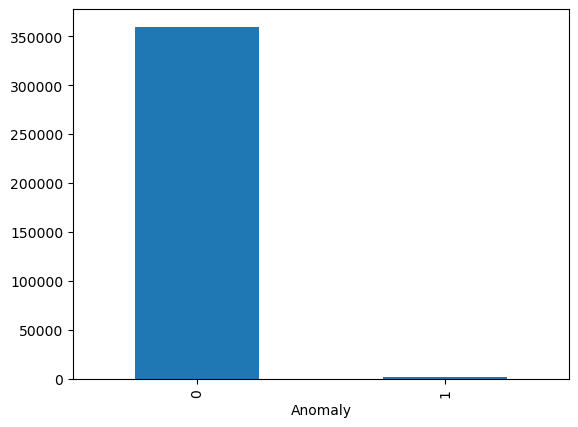

In [5]:
df["Anomaly"].value_counts().plot(kind='bar')

In [6]:
# 🔬 Scale Features
features = [
    'diff',
    'part_of_day_Afternoon', 'part_of_day_Evening', 'part_of_day_Morning', 'part_of_day_Night',
    'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
    'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'
]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

In [7]:
# 🏗️ Train/Test Split & SMOTE
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X_scaled,
    df['Anomaly'].values,
    df[['user key', 'datetime']],
    test_size=0.2,
    random_state=42
)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [8]:
# 🚀 Train XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=4, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:50:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [10]:
# 💾 Save model & scaler
os.makedirs("./models/xgboost", exist_ok=True)
pickle.dump(xgb_model, open("./models/xgboost/XGBoost.pkl", "wb"))
pickle.dump(scaler, open("./models/xgboost/standard_scaler.pkl", "wb"))

In [11]:
# Split your original DataFrame (with all columns)
df_train, df_test, y_train, y_test = train_test_split(
    df,
    df['Anomaly'].values,
    test_size=0.2,
    random_state=42
)
reference_df = df_train[features].reset_index(drop=True)
reference_df['Anomaly'] = y_train
reference_df.to_csv("./models/xgboost/reference_data.csv", index=False)

In [12]:
# Print evaluation scores
acc = accuracy_score(y_test, y_pred_xgb)
prec = precision_score(y_test, y_pred_xgb)
rec = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9991
Precision: 0.8658
Recall: 0.9950
F1 Score: 0.9259


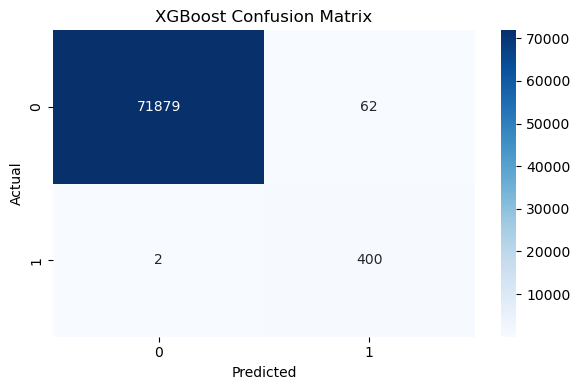

In [13]:
# Plot and show confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

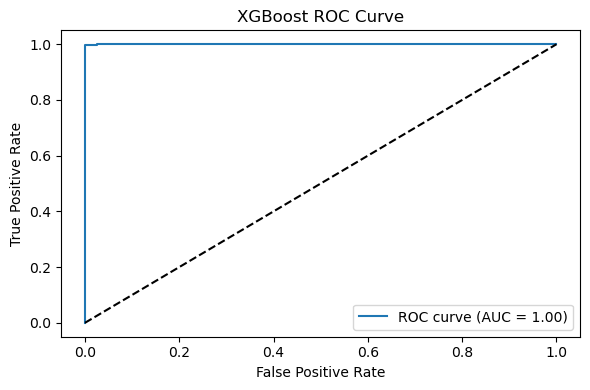

In [14]:
# Plot and show ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [18]:
# 🧩 MLflow PyFunc Wrapper
class XGBModelWrapper(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        self.scaler = pickle.load(open("./models/xgboost/standard_scaler.pkl", "rb"))
        self.model = pickle.load(open("./models/xgboost/XGBoost.pkl", "rb"))

    def predict(self, context, model_input: List[Tuple[float, float, Any]]):
        meter_readings = np.array([x[0] for x in model_input])
        diffs = np.array([x[1] for x in model_input])
        timestamps = [x[2] for x in model_input]

        hours, weekdays = [], []
        for ts in timestamps:
            dt = pd.to_datetime(ts)
            hours.append(dt.hour)
            weekdays.append(dt.weekday())

        hours, weekdays = np.array(hours), np.array(weekdays)
        part_of_day = np.zeros((len(hours), 4))
        part_of_day[(5 <= hours) & (hours < 12), 0] = 1
        part_of_day[(12 <= hours) & (hours < 17), 1] = 1
        part_of_day[(17 <= hours) & (hours < 21), 2] = 1
        part_of_day[(hours >= 21) | (hours < 5), 3] = 1

        day_of_week = np.eye(7)[weekdays]
        features_input = np.column_stack((diffs, part_of_day, day_of_week))  
        scaled = self.scaler.transform(features_input)
        preds = self.model.predict(scaled)
        return preds.tolist()

/opt/conda/lib/python3.11/site-packages/mlflow/pyfunc/model.py:175: UserWarning: Type hint used in the model's predict function is not supported for MLflow's schema validation. Unsupported type hint `typing.Tuple[float, float, typing.Any]`. Type hints must be a list[...] where collection element type is one of these types: [<class 'int'>, <class 'str'>, <class 'bool'>, <class 'float'>, <class 'bytes'>, <class 'datetime.datetime'>], pydantic BaseModel subclasses, lists and dictionaries of primitive types, or typing.Any. Check https://mlflow.org/docs/latest/model/python_model.html#supported-type-hints for more details. Remove the type hint to disable this warning. To enable validation for the input data, specify input example or model signature when logging the model. 
  func_info = _get_func_info_if_type_hint_supported(predict_attr)


In [19]:
# 🔍 Test wrapper
tester = XGBModelWrapper()
tester.load_context(None)
sample_inputs = list(zip(df['meter reading'].iloc[:5], df['diff'].iloc[:5], df['datetime'].iloc[:5]))
predictions = tester.predict(None, sample_inputs)
print("Sample predictions:", predictions)

Sample predictions: [0, 0, 0, 0, 0]


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


2025/07/18 08:51:20 INFO mlflow.models.signature: Inferring model signature from type hints
/opt/conda/lib/python3.11/site-packages/mlflow/pyfunc/__init__.py:3153: UserWarning: Failed to infer signature from type hint: Unsupported type hint `typing.Tuple[float, float, typing.Any]`. Type hints must be a list[...] where collection element type is one of these types: [<class 'int'>, <class 'str'>, <class 'bool'>, <class 'float'>, <class 'bytes'>, <class 'datetime.datetime'>], pydantic BaseModel subclasses, lists and dictionaries of primitive types, or typing.Any. Check https://mlflow.org/docs/latest/model/python_model.html#supported-type-hints for more details.
  signature_from_type_hints = _infer_signature_from_type_hints(
/opt/conda/lib/python3.11/site-packages/mlflow/pyfunc/__init__.py:3224: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter. See https://mlflow.org/docs/latest/m

Registered model 'DemoXGBoost' already exists. Creating a new version of this model...
2025/07/18 08:51:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DemoXGBoost, version 2
Created version '2' of model 'DemoXGBoost'.


🏃 View run unruly-stag-100 at: http://10.149.59.75:5000/#/experiments/137/runs/e996bd84b88a4936b912f62f2f2b4f5c
🧪 View experiment at: http://10.149.59.75:5000/#/experiments/137


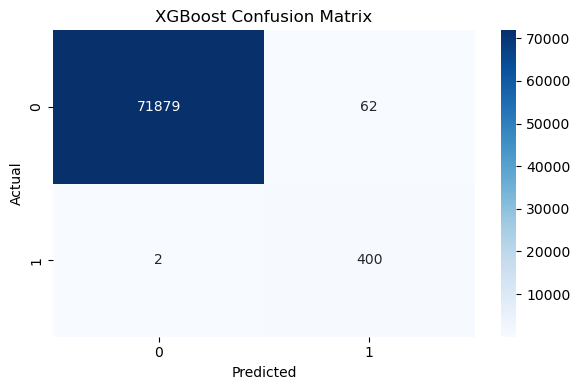

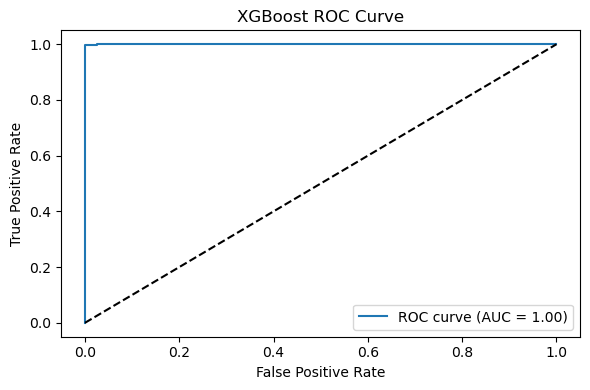

In [20]:
# 🚀 Log to MLflow
def log_experiment():
    with mlflow.start_run():
        mlflow.log_param("model_type", "XGBoost")
        mlflow.log_param("n_estimators", 100)
        mlflow.log_param("max_depth", 4)
        mlflow.log_param("smote", True)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)

        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("XGBoost Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.savefig("./models/xgboost/confusion_matrix.png")
        mlflow.log_artifact("./models/xgboost/confusion_matrix.png")

        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('XGBoost ROC Curve')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig("./models/xgboost/roc_curve.png")
        mlflow.log_artifact("./models/xgboost/roc_curve.png")

        mlflow.log_artifact("models/xgboost/reference_data.csv")

        column_mapping = {
            "numerical_features": features,
            "categorical_features": [],
            "text_features": [],
            "input_features": features,
            "predicted_features": ["prediction"]
        }
        mlflow.log_param("column_mapping", json.dumps(column_mapping))

        signature = infer_signature(reference_df[features], xgb_model.predict(scaler.transform(reference_df[features])))
        mlflow.pyfunc.log_model(
            artifact_path="model",
            python_model=XGBModelWrapper(),
            artifacts={
                "standard_scaler": "./models/xgboost/standard_scaler.pkl",
                "model": "./models/xgboost/XGBoost.pkl"
            },
            registered_model_name="DemoXGBoost",
            signature=signature
        )

# ✅ Execute MLflow logging
if MLFLOW_LOGGING:
    log_experiment()